Домашее задание номер 2. Взять произвольную аудиозапись. Получить ее мел спектрограмму (используя вашу реализацию!). Прогнать любой алгоритм шумоподавления (или написать свой!). И получить мелспектрограмму полученного сигнала. Посчитать метрики до и после. Выбор метрик зависит от вас - ориентируйтесь на лекцию.

In [9]:
import torch
import librosa
import numpy as np
import soundfile as sf
from MPSENet import MPSENet
import matplotlib.pyplot as plt

# Построение мел спектрограммы

In [ ]:
def hz_to_mel(hz):
    return 2595 * np.log10(1 + hz / 700.0)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595.0) - 1)

def compute_mel_spectrogram(amplitudes, sr=16000,
                            window_size=0.03, step_size=0.01,
                            NFFT=2048, n_mels=80, fmin=0, fmax=None):
    if fmax is None:
        fmax = sr // 2

    # mono
    if amplitudes.ndim == 2:
        amplitudes = amplitudes.mean(axis=1)

    frame_size = int(window_size * sr)
    hop_size = int(step_size * sr)
    # pad end if needed
    pad_len = (frame_size - (len(amplitudes) - frame_size) % hop_size) % hop_size
    if pad_len:
        amplitudes = np.concatenate([amplitudes, np.zeros(pad_len)])

    frames = []
    for start in range(0, len(amplitudes) - frame_size + 1, hop_size):
        frame = amplitudes[start:start + frame_size]
        frame = frame * np.hamming(frame_size)
        frames.append(frame)
    frames = np.array(frames)  # shape (num_frames, frame_size)

    mag_frames = np.abs(np.fft.rfft(frames, n=NFFT))
    power_frames = (1.0 / NFFT) * (mag_frames ** 2)

    # Перевод частот в Mel

    # равномерные узлы в mel и в hz
    mel_points = np.linspace(hz_to_mel(fmin), hz_to_mel(fmax), n_mels + 2)
    hz_points = mel_to_hz(mel_points)

    # индексы в спектре
    bin_points = np.floor((NFFT + 1) * hz_points / sr).astype(int)

    # треугольные фильтры Mel
    filters = np.zeros((n_mels, NFFT//2 + 1))
    for i in range(1, n_mels + 1):
        left = bin_points[i - 1]
        center = bin_points[i]
        right = bin_points[i + 1]
        if center > left:
            filters[i-1, left:center] = np.linspace(0, 1, center - left)
        if right > center:
            filters[i-1, center:right] = np.linspace(1, 0, right - center)
    
    # Проекция мощности на Mel полосы
    mel_energy = np.dot(power_frames, filters.T)  # (num_frames, n_mels)
    mel_db = 10 * np.log10(np.maximum(mel_energy, 1e-10)) # в dB
    duration = len(amplitudes) / sr

    return mel_db, (0, duration, fmin, fmax)

## Визуализация Mel спектрограммы

In [16]:
def plot_mel_spectrogram(mel_db, start, duration, fmin, fmax, title="Mel-спектрограмма"): 
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_db.T, 
            origin='lower', 
            aspect='auto', 
            extent=[start, duration, fmin, fmax],
            cmap=None
            )
    plt.xlabel("Время (с)")
    plt.ylabel("Частота (Гц)")
    plt.title(title)
    plt.colorbar(label="Гц")
    plt.show()

# Расчёт метрик

In [83]:
def si_sdr(reference, estimation, eps=1e-8):
    L = min(len(reference), len(estimation))
    ref = reference[:L]
    est = estimation[:L]

    ref = ref / (np.max(np.abs(ref)) + 1e-8)
    est = est / (np.max(np.abs(est)) + 1e-8)

    ref_energy = np.sum(ref**2)
    if ref_energy < eps:
        return np.nan

    scale = np.sum(est * ref) / (ref_energy + eps)
    s_target = scale * ref
    e_noise = est - s_target

    return 10 * np.log10((np.sum(s_target**2) + eps) / (np.sum(e_noise**2) + eps))

def sdr(reference, estimation, eps=1e-8):
    L = min(len(reference), len(estimation))
    ref = reference[:L]
    est = estimation[:L]

    ref = ref / (np.max(np.abs(ref)) + 1e-8)
    est = est / (np.max(np.abs(est)) + 1e-8)
    
    return 10 * np.log10((np.sum(ref**2) + eps) / (np.sum((ref - est)**2) + eps))

def stft_distance(reference, estimation, n_fft=1024, hop_length=256):
    L = min(len(reference), len(estimation))
    ref = reference[:L]
    est = estimation[:L]

    S_ref = np.abs(librosa.stft(ref, n_fft=n_fft, hop_length=hop_length))
    S_est = np.abs(librosa.stft(est, n_fft=n_fft, hop_length=hop_length))
    diff = S_ref - S_est
    return np.linalg.norm(diff) / np.prod(diff.shape)


# Добавим шум к исходному аудио

In [ ]:
# Загрузка аудиофайла
path_for_audio = "homework2_mp3s\The war begins.mp3"

audio_clean, sr_clean = librosa.load(path_for_audio, sr=16000, mono=True)

In [196]:
snr_db = 20
signal_power = np.mean(audio_clean**2)
noise_power = signal_power / (10**(snr_db/10))
noise = np.random.randn(len(audio_clean)) * np.sqrt(noise_power)
audio_noisy = audio_clean + noise

sf.write(f"{path_for_audio.split('.')[0]}_noisy.mp3", audio_noisy, 16000)

# Denoising с помощью MPSENet

In [197]:
# Загрузка модели
model = MPSENet.from_pretrained("JacobLinCool/MP-SENet-DNS").to("cpu")
model.eval()

audio_tensor_noisy = torch.tensor(audio_noisy.astype(np.float32), device="cpu")

# Обработка аудио
with torch.no_grad():
    audio_denoised = model(audio_tensor_noisy)[0]
    sf.write(f"{path_for_audio.split('.')[0]}_denoised.mp3", audio_denoised, 16000)

# Mel спектрограммы

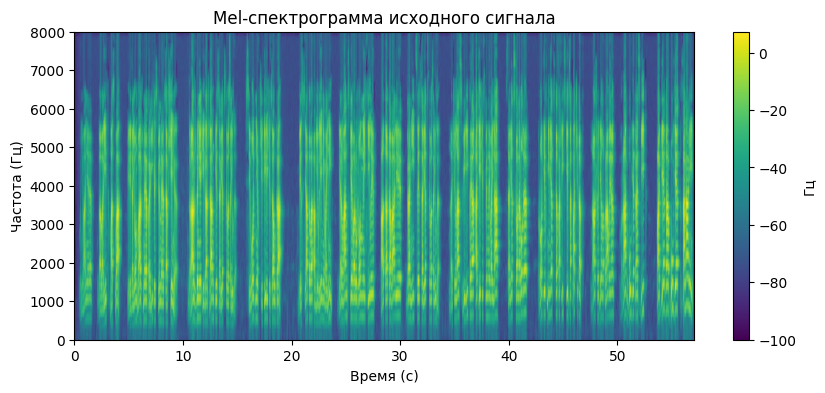

In [198]:
mel_spec = compute_mel_spectrogram(audio_clean, sr_clean)
plot_mel_spectrogram(mel_spec[0], *mel_spec[1], title="Mel-спектрограмма исходного сигнала")

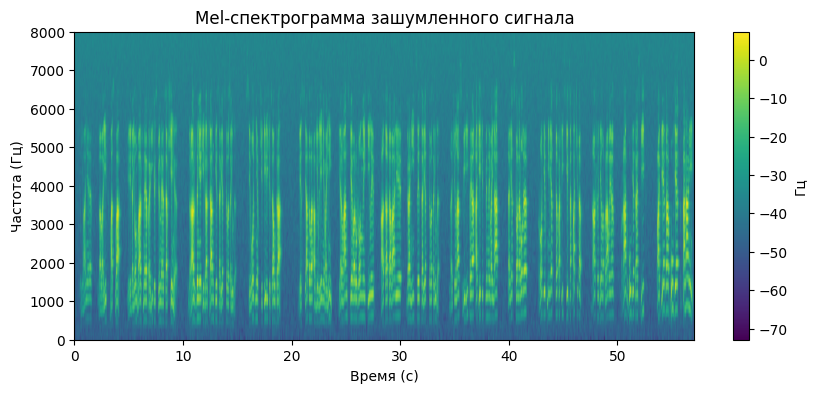

In [199]:
mel_spec_noisy = compute_mel_spectrogram(audio_noisy, sr_clean)
plot_mel_spectrogram(mel_spec_noisy[0], *mel_spec_noisy[1], title="Mel-спектрограмма зашумленного сигнала")

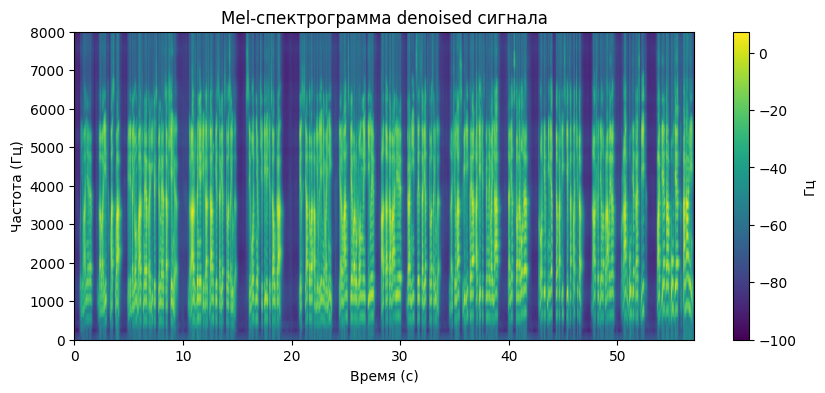

In [200]:
mel_spec_denoised = compute_mel_spectrogram(audio_denoised, sr=16000)
plot_mel_spectrogram(mel_spec_denoised[0], *mel_spec_denoised[1], title="Mel-спектрограмма denoised сигнала")

# Метрики до и после

In [201]:
si_sdr_value = si_sdr(audio_clean, audio_denoised)
sdr_value = sdr(audio_clean, audio_denoised)
stft_dist = stft_distance(audio_clean, audio_denoised, sr_clean)

si_sdr_noise = si_sdr(audio_clean, audio_noisy)
sdr_noise = sdr(audio_clean, audio_noisy)
stft_distance_noise = stft_distance(audio_clean, audio_noisy, sr_clean)

In [202]:
print("Метрики качества:")
print(f"SI-SDR (clean vs denoised): {si_sdr_value:.2f} dB")
print(f"SI-SDR (clean vs noisy): {si_sdr_noise:.2f} dB")
print('-'*40)
print(f"SDR (clean vs denoised): {sdr_value:.2f} dB")
print(f"SDR (clean vs noisy): {sdr_noise:.2f} dB")
print('-'*40)
print(f"STFT Distance (clean vs denoised): {stft_dist:.6f}")
print(f"STFT Distance (clean vs noisy): {stft_distance_noise:.6f}")


Метрики качества:
SI-SDR (clean vs denoised): 25.20 dB
SI-SDR (clean vs noisy): 20.00 dB
----------------------------------------
SDR (clean vs denoised): 25.21 dB
SDR (clean vs noisy): 20.00 dB
----------------------------------------
STFT Distance (clean vs denoised): 0.000053
STFT Distance (clean vs noisy): 0.000112


На других аудиозаписях постоянно метрики выбивались хуже, чем у зашумленного аудио(  
    Но там были аплодисменты \ музыка \ сильные искажения, которые модель вырезала